<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [45]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [46]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [47]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Check whether GPU is available

In [48]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv file

In [49]:
from darts import TimeSeries
import pandas as pd


In [50]:
data_file_name = 'data/market_data.csv'

In [51]:

# load into a dataframe with valid market calendar days
# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])
# raw_df


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.054893,0.062965,0.054893,0.060274,1.031789e+09,0.0,0.0
1986-03-14,0.060274,0.063504,0.060274,0.062427,3.081600e+08,0.0,0.0
1986-03-17,0.062427,0.064042,0.062427,0.063504,1.331712e+08,0.0,0.0
1986-03-18,0.063504,0.064042,0.061350,0.061889,6.776640e+07,0.0,0.0
1986-03-19,0.061889,0.062427,0.060274,0.060812,4.789440e+07,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-01,374.929993,376.529999,370.125000,373.455002,2.199080e+07,0.0,0.0
2024-01-02,373.859985,375.899994,366.769989,370.869995,2.525860e+07,0.0,0.0
2024-01-03,369.010010,373.260010,368.510010,370.600006,2.308350e+07,0.0,0.0


In [52]:
# raw_df.index

DatetimeIndex(['1986-03-13', '1986-03-14', '1986-03-17', '1986-03-18',
               '1986-03-19', '1986-03-20', '1986-03-21', '1986-03-24',
               '1986-03-25', '1986-03-26',
               ...
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2024-01-01', '2024-01-02', '2024-01-03',
               '2024-01-04', '2024-01-05'],
              dtype='datetime64[ns]', name='Date', length=9867, freq=None)

In [53]:
# type(raw_df.index)

pandas.core.indexes.datetimes.DatetimeIndex

In [54]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

0

In [55]:
# raw_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.054893,0.062965,0.054893,0.060274,1.031789e+09,0.0,0.0
1986-03-14,0.060274,0.063504,0.060274,0.062427,3.081600e+08,0.0,0.0
1986-03-17,0.062427,0.064042,0.062427,0.063504,1.331712e+08,0.0,0.0
1986-03-18,0.063504,0.064042,0.061350,0.061889,6.776640e+07,0.0,0.0
1986-03-19,0.061889,0.062427,0.060274,0.060812,4.789440e+07,0.0,0.0
...,...,...,...,...,...,...,...
2024-01-01,374.929993,376.529999,370.125000,373.455002,2.199080e+07,0.0,0.0
2024-01-02,373.859985,375.899994,366.769989,370.869995,2.525860e+07,0.0,0.0
2024-01-03,369.010010,373.260010,368.510010,370.600006,2.308350e+07,0.0,0.0


In [133]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')
# series = TimeSeries.from_dataframe(raw_df, freq='B')


# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


In [134]:
# check for any data gaps
gaps = series.gaps(mode='any')


In [135]:
type(gaps)

pandas.core.frame.DataFrame

In [136]:
# there should be no data gaps
assert(len(gaps.index) == 0)

In [137]:
series

<TimeSeries (DataArray) (Date: 9867, component: 7, sample: 1)>
array([[[5.48928341e-02],
        [6.29653825e-02],
        [5.48928341e-02],
        ...,
        [1.03178880e+09],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[6.02741448e-02],
        [6.35035369e-02],
        [6.02741448e-02],
        ...,
        [3.08160000e+08],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[6.24266277e-02],
        [6.40416324e-02],
        [6.24266277e-02],
        ...,
...
        ...,
        [2.30835000e+07],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.70670013e+02],
        [3.73100006e+02],
        [3.67170013e+02],
        ...,
        [2.09015000e+07],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.68970001e+02],
        [3.72059998e+02],
        [3.66500000e+02],
        ...,
        [2.09870000e+07],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 2024-01-05
  * component  (component) object 'Open' 'High' ... 'Dividends' 'Stock Splits'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [141]:
# add holidays
series_with_holidays = series.add_holidays(country_code='US')

In [142]:
series_with_holidays

<TimeSeries (DataArray) (Date: 9867, component: 8, sample: 1)>
array([[[5.48928341e-02],
        [6.29653825e-02],
        [5.48928341e-02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[6.02741448e-02],
        [6.35035369e-02],
        [6.02741448e-02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[6.24266277e-02],
        [6.40416324e-02],
        [6.24266277e-02],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.70670013e+02],
        [3.73100006e+02],
        [3.67170013e+02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[3.68970001e+02],
        [3.72059998e+02],
        [3.66500000e+02],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 2024-01-05
  * component  (component) object 'Open' 'High' ... 'Stock Splits' 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [143]:
from darts.dataprocessing.transformers import Scaler

ser_scaler = Scaler(verbose=True, n_jobs=-1)
series_scaled = ser_scaler.fit_transform(series=series_with_holidays)
series_scaled

Fitting (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

<TimeSeries (DataArray) (Date: 9867, component: 8, sample: 1)>
array([[[0.00000000e+00],
        [1.54069995e-05],
        [0.00000000e+00],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.40245998e-05],
        [1.68075570e-05],
        [1.42323141e-05],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[1.96343318e-05],
        [1.82079614e-05],
        [1.99251303e-05],
        ...,
...
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.65885270e-01],
        [9.70851822e-01],
        [9.70934034e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]],

       [[9.61454753e-01],
        [9.68145179e-01],
        [9.69162005e-01],
        ...,
        [0.00000000e+00],
        [0.00000000e+00],
        [0.00000000e+00]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 2024-01-05
  * component  (component) object 'Open' 'High' ... 'Stock Splits' 'holidays'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [144]:
# series = TimeSeries.from_dataframe(raw_df[['Close']], freq='B')
target = series_scaled.univariate_component('Close')
target

<TimeSeries (DataArray) (Date: 9867, component: 1, sample: 1)>
array([[[1.12507368e-05]],

       [[1.68761734e-05]],

       [[1.96903910e-05]],

       ...,

       [[9.68377905e-01]],

       [[9.61426265e-01]],

       [[9.60929714e-01]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 2024-01-05
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [174]:

# open = TimeSeries.from_dataframe(raw_df[['Open']], freq='B')
# low = TimeSeries.from_dataframe(raw_df[['Low']], freq='B')
# high = TimeSeries.from_dataframe(raw_df[['High']], freq='B')
# volume = TimeSeries.from_dataframe(raw_df[['Volume']], freq='B')
# dividends = TimeSeries.from_dataframe(raw_df[['Dividends']], freq='B')
# stock_splits = TimeSeries.from_dataframe(raw_df[['Stock Splits']], freq='B')

# past_covariates = open.stack(low).stack(high).stack(volume).stack(dividends).stack(stock_splits)

past_covariates = series_scaled.drop_columns(col_names=['Close', 'holidays'])
past_covariates

future_covariates = series_scaled.univariate_component('holidays')

Prepare train and validation splits

In [175]:
val_start = pd.Timestamp('2023-05-05')
train, val = target.split_before(val_start)

past_covariates_train, past_covariates_pred = past_covariates.split_before(val_start)


In [176]:
len(train), len(val)

(9691, 176)

In [177]:
train.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[1.12507368e-05]],

       [[1.68761734e-05]],

       [[1.96903910e-05]],

       [[1.54697510e-05]],

       [[1.26570814e-05]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1986-03-13 1986-03-14 ... 1986-03-19
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [178]:
# there should be no gaps in the training data
assert(len(train.gaps().index) == 0)


In [179]:
val.head()

<TimeSeries (DataArray) (Date: 5, component: 1, sample: 1)>
array([[[0.80658509]],

       [[0.80139124]],

       [[0.79710627]],

       [[0.8108959 ]],

       [[0.80518269]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-05-11
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [180]:
# there should be no gaps in the validation data
assert(len(val.gaps().index) == 0)


Plot data splits

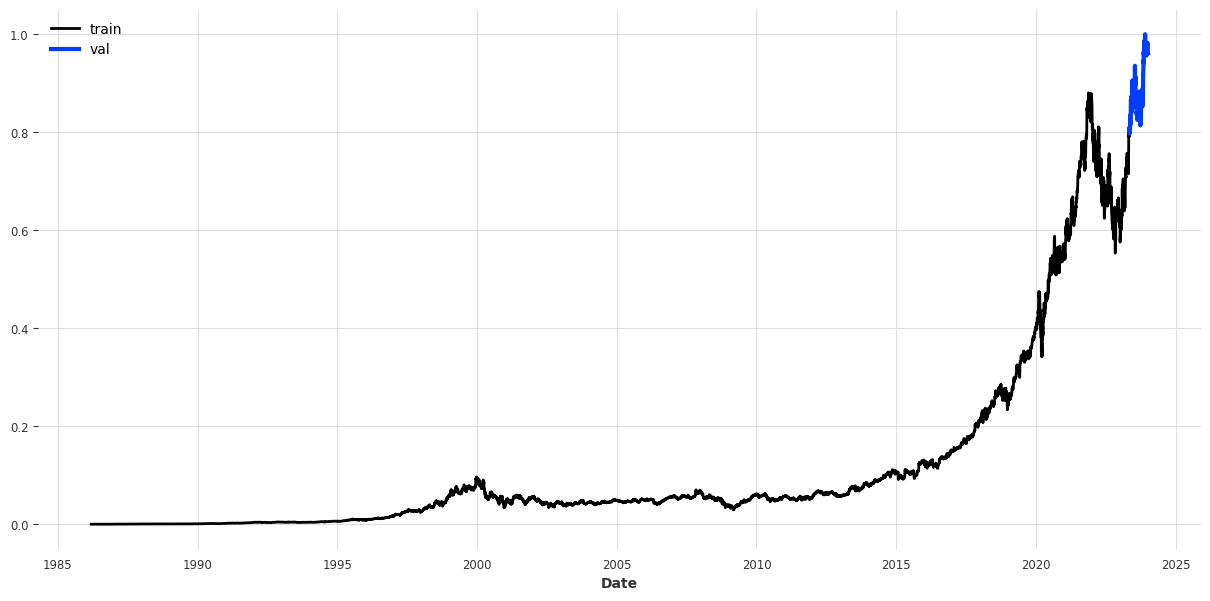

In [181]:
import matplotlib.pyplot as plt

train.plot(label='train')
val.plot(label='val', lw=3)
plt.legend()

Show seasonalities

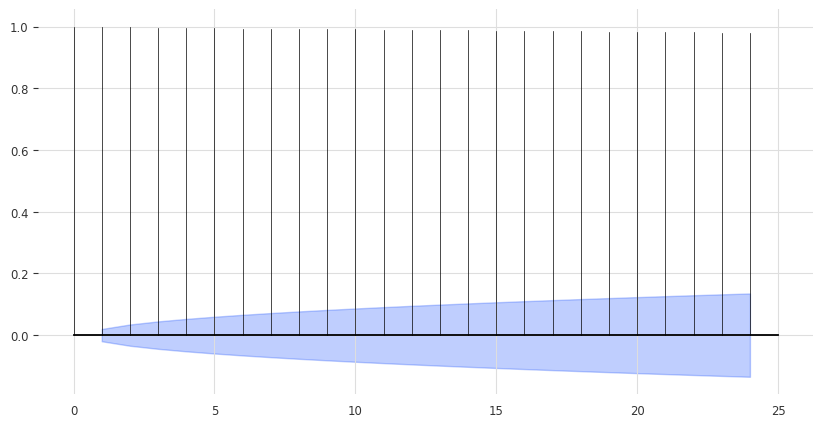

In [182]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train, alpha=0.05)

Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [183]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    "transformer": scaler
}



In [192]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 100 # model training epochs

Model hyperparameter selection

In [185]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [186]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      add_encoders=encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [187]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [193]:
# train model

model.fit(train, epochs=n_epochs, past_covariates=past_covariates_train, future_covariates=future_covariates, num_loader_workers=10) # 


Fitting (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Fitting (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 1.6 K 
5 | future_cov_projection | _ResidualBlock   | 2.2 K 
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------------------
2.6 M     Trainable params
0         Non-trainable params
2.6 M     Total params
10.433    Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


TiDEModel(num_encoder_layers=1, num_decoder_layers=1, decoder_output_dim=16, hidden_size=128, temporal_width_past=4, temporal_width_future=4, temporal_decoder_hidden=32, use_layer_norm=False, dropout=0.1, use_static_covariates=True, optimizer_kwargs={'lr': 0.001}, pl_trainer_kwargs={'gradient_clip_val': 1, 'max_epochs': 200, 'accelerator': 'auto', 'callbacks': []}, lr_scheduler_cls=<class 'torch.optim.lr_scheduler.ExponentialLR'>, lr_scheduler_kwargs={'gamma': 0.999}, batch_size=256, random_state=42, input_chunk_length=504, output_chunk_length=42, add_encoders={'cyclic': {'future': ['dayofweek', 'month', 'quarter']}, 'datetime_attribute': {'future': ['dayofweek', 'month', 'quarter', 'year']}, 'position': {'past': ['relative'], 'future': ['relative']}, 'transformer': Scaler}, n_epochs=10, use_reversible_instance_norm=True, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), model_name=data/canswim_model.pt)

In [194]:
# save model
model.save(saved_model_name)


In [195]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

In [196]:
pred

<TimeSeries (DataArray) (Date: 42, component: 1, sample: 500)>
array([[[0.75346429, 0.75481979, 0.78647773, ..., 0.75543662,
         0.75948052, 0.75903978]],

       [[0.73781621, 0.72400384, 0.71062153, ..., 0.73050729,
         0.7311721 , 0.75595692]],

       [[0.7548566 , 0.72538027, 0.72663101, ..., 0.73673041,
         0.73043434, 0.74806565]],

       ...,

       [[0.7199205 , 0.72763815, 0.73766739, ..., 0.7224694 ,
         0.74091493, 0.70666646]],

       [[0.74317698, 0.77213029, 0.74848599, ..., 0.73653934,
         0.73608564, 0.726195  ]],

       [[0.75291384, 0.72728099, 0.75185846, ..., 0.71060417,
         0.74263612, 0.76510016]]])
Coordinates:
  * Date       (Date) datetime64[ns] 2023-05-05 2023-05-08 ... 2023-07-03
  * component  (component) object 'Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

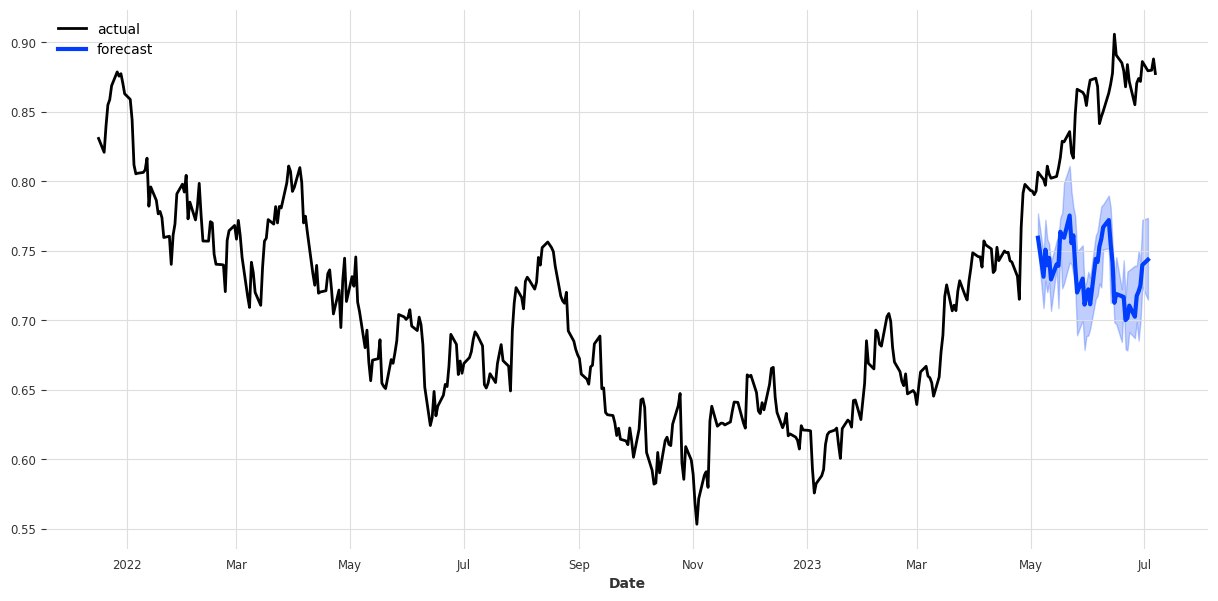

In [197]:
# select a reasonable range of train and val data points for convenient visualization of results
actual = target.slice(val_start-pd.Timedelta(days=train_history), val_start+pd.Timedelta(days=pred_horizon+21))
actual.plot(label='actual')
pred.plot(label='forecast', lw=3)
plt.legend()

Backtest Model


Backtest model on the full range of test data

In [198]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [203]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=200)
forecast_horizon = pred_horizon # pred_horizon
backtest = eval_model(model=model, series=target, start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_covariates, future_covariates=future_covariates)


Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

Transform (Scaler):   0%|          | 0/1 [00:00<?, ?it/s]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

Backtest RMSE = 0.08362995828132241


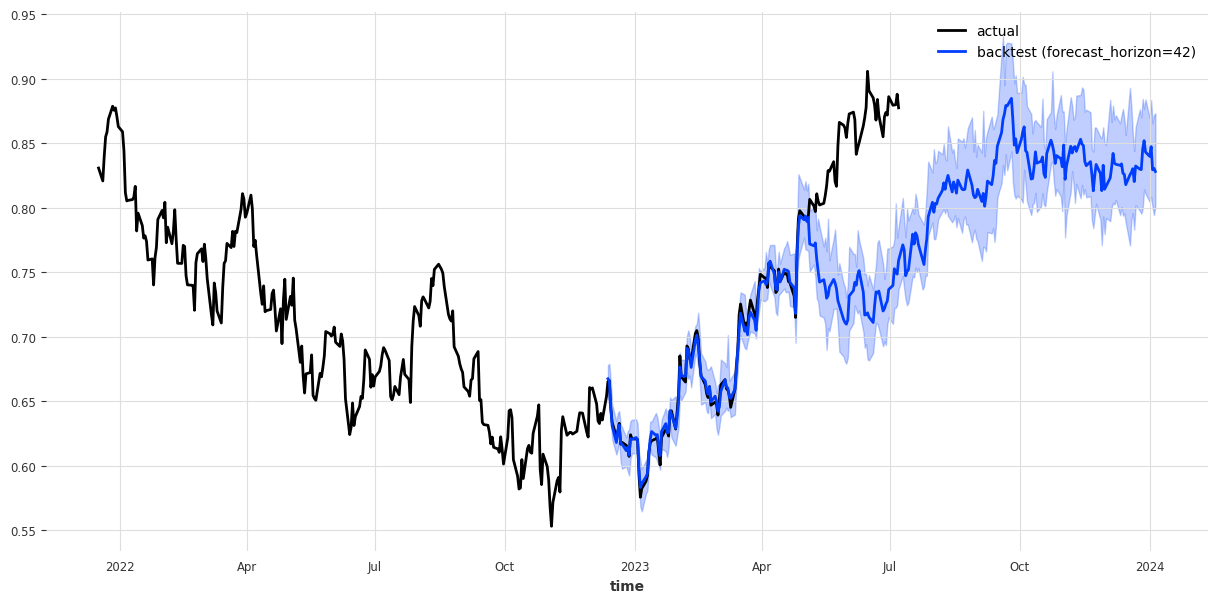

In [204]:

# plot results
actual.plot(label='actual')
backtest.plot(label=f'backtest (forecast_horizon={forecast_horizon})')
print('Backtest RMSE = {}'.format(rmse(target, backtest)))